# Using `salter` to examine the transit residuals

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from salter import LightCurve
import matplotlib.pyplot as plt
import h5py

# Open the HDF5 archive of Kepler light curves
hdf5_file = h5py.File("data/light_curves.hdf5", 'r')

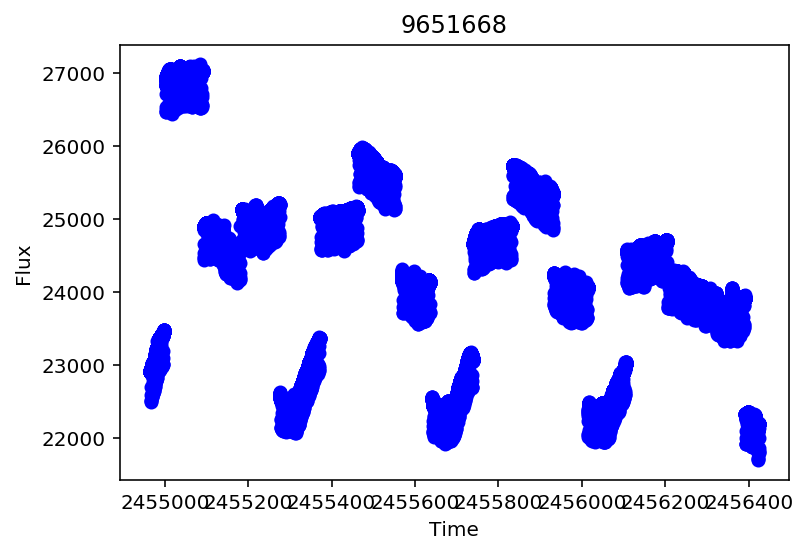

In [2]:
# Specify a KIC number to get the light curve
# Here are some numbers to try: 4157325, 9651668, 9705459, 10386922
kic_number = 9651668
whole_lc = LightCurve.from_hdf5(hdf5_file, kic_number)

# Plot the light curve (raw SAP flux)
whole_lc.plot()

Here's how you can quickly see what the transit parameters are:

In [3]:
for attr in dir(whole_lc.params):
    if not attr.startswith('_'):
        print("{0}: {1}".format(attr, getattr(whole_lc.params, attr)))

a: 8.537133444823754
b: 0.076
duration: 0.11224250000000001
ecc: 0
fp: None
inc: 89.48992987059387
limb_dark: quadratic
per: 2.684328541
rp: 0.12077242172781003
t0: 2454966.3548095
t_secondary: None
u: (0.49869999999999998, 0.1772)
w: 90


Mask the out-of-transit portions of the light curve, normalize each transit with the "subtract-add-divide" method.

In [4]:
from salter import subtract_add_divide

extra_oot_time = 1.0 # [durations]; Extra transit durations to keep before ingress/after egress

# Mask out-of-transit portions of light curves, chop into individual transits
near_transit = LightCurve(**whole_lc.mask_out_of_transit(oot_duration_fraction=extra_oot_time))
transits = near_transit.get_transit_light_curves()

# Normalize all transits with the subtract-add-divide method, 
# using a second order polynomial
subtract_add_divide(whole_lc, transits)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:880: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:881: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/salter/salter/lightcurve.py:346: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/salter/salter/lightcurve.py:347: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/salter/salter/lightcurve.py:348: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the f

Plot the residuals from the transit model given the parameters from the KOI catalog.

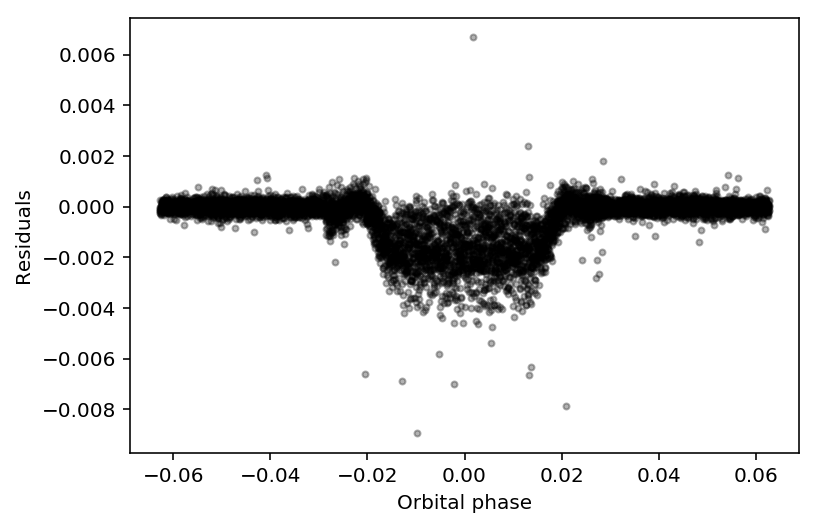

In [5]:
from salter import concatenate_transit_light_curves

normed_transits = concatenate_transit_light_curves(transits)

plt.plot(normed_transits.phases(), 
         normed_transits.fluxes - normed_transits.transit_model(), 
         'k.', alpha=0.3)
plt.xlabel('Orbital phase')
plt.ylabel('Residuals')

Solve for better $R_p/R_\star$, $u_1$, $u_2$ parameters: 

In [ ]:
from salter import concatenate_transit_light_curves

normed_transits = concatenate_transit_light_curves(transits)

# Solve for better parameters for: Rp/Rs, u1, u2
normed_transits.fit_lc_3param()

Store residuals in a `Residuals` object, which has handy methods for statistical analysis.

(<matplotlib.figure.Figure at 0x127e548d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126df8550>)

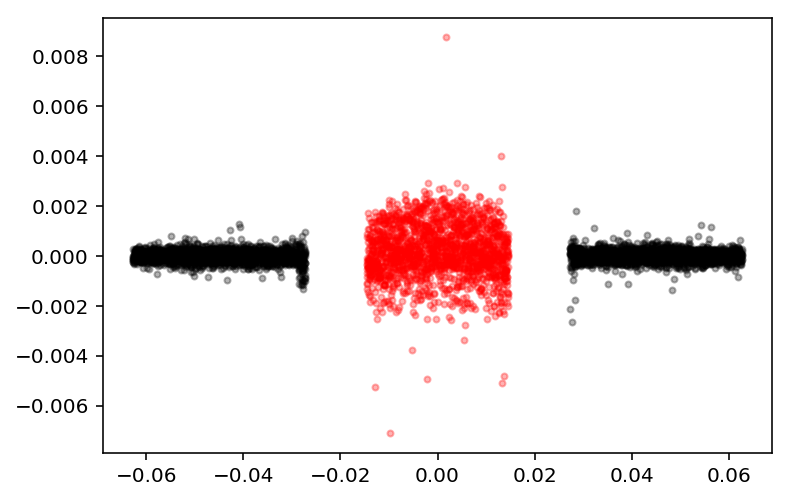

In [7]:
from salter import Residuals

r = Residuals(normed_transits, normed_transits.params, buffer_duration=0.3)

r.plot()

### Out-of-transit: before vs after transit

In [8]:
# Two sample KS test: are the distributions of the two samples the same?
print(r.ks(['out_of_transit', 'before_midtransit'], 
           ['out_of_transit', 'after_midtransit']))

# k-sample Anderson test: are the distributions of the two samples the same?
print(r.anderson(['out_of_transit', 'before_midtransit'], 
                 ['out_of_transit', 'after_midtransit']))

# Independent sample T-test: are the means the two samples the same?
print(r.ttest(['out_of_transit', 'before_midtransit'], 
              ['out_of_transit', 'after_midtransit']))

0.31601080156
0.22773226884203276
0.137151922647


### In-transit: before vs after mid-transit

In [9]:
# Two sample KS test: are the distributions of the two samples the same?
print(r.ks(['in_transit', 'before_midtransit'], 
           ['in_transit', 'after_midtransit']))

# k-sample Anderson test: are the distributions of the two samples the same?
print(r.anderson(['in_transit', 'before_midtransit'], 
                 ['in_transit', 'after_midtransit']))

# Independent sample T-test: are the means the two samples the same?
print(r.ttest(['in_transit', 'before_midtransit'], 
              ['in_transit', 'after_midtransit']))

0.98871231087
0.8551302501703942
0.86317809199


/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


### In-transit vs out-of-transit

In [10]:
# Two sample KS test: are the distributions of the two samples the same?
print(r.ks('in_transit', 'out_of_transit'))

# k-sample Anderson test: are the distributions of the two samples the same?
print(r.anderson('in_transit', 'out_of_transit'))

# Independent sample T-test: are the means the two samples the same?
print(r.ttest('in_transit', 'out_of_transit'))

3.86329770054e-167
0
1.68390593575e-14


/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
